Device: cpu
Train: torch.Size([800, 4]) torch.Size([800, 1])
Test:  torch.Size([200, 4]) torch.Size([200, 1])
Epoch   1 | Train RMSE=0.8584 | Test RMSE=0.8975
Epoch  25 | Train RMSE=0.3002 | Test RMSE=0.3263
Epoch  50 | Train RMSE=0.1717 | Test RMSE=0.1823
Epoch  75 | Train RMSE=0.1330 | Test RMSE=0.1402
Epoch 100 | Train RMSE=0.1120 | Test RMSE=0.1172
Epoch 125 | Train RMSE=0.0979 | Test RMSE=0.1018
Epoch 150 | Train RMSE=0.0878 | Test RMSE=0.0907
Epoch 175 | Train RMSE=0.0802 | Test RMSE=0.0824
Epoch 200 | Train RMSE=0.0743 | Test RMSE=0.0761
Epoch 225 | Train RMSE=0.0695 | Test RMSE=0.0711
Epoch 250 | Train RMSE=0.0656 | Test RMSE=0.0670

=== Parámetros aprendidos de las funciones de membresía (Gaussianas) ===

Variable x1:
  Conjunto 1: mu=0.5791, sigma=0.2712
  Conjunto 2: mu=0.9407, sigma=0.2166

Variable x2:
  Conjunto 1: mu=1.0303, sigma=0.4026
  Conjunto 2: mu=1.4007, sigma=0.2428

Variable x3:
  Conjunto 1: mu=0.2028, sigma=0.2756
  Conjunto 2: mu=0.4630, sigma=0.2680

Variab

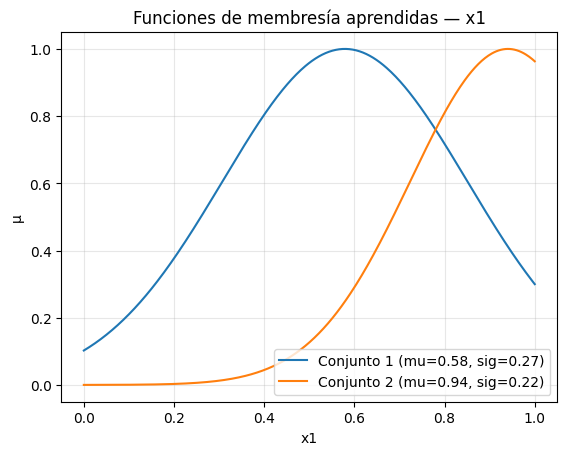

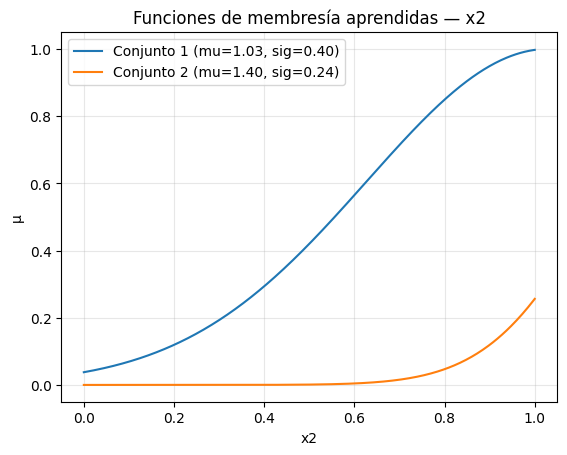

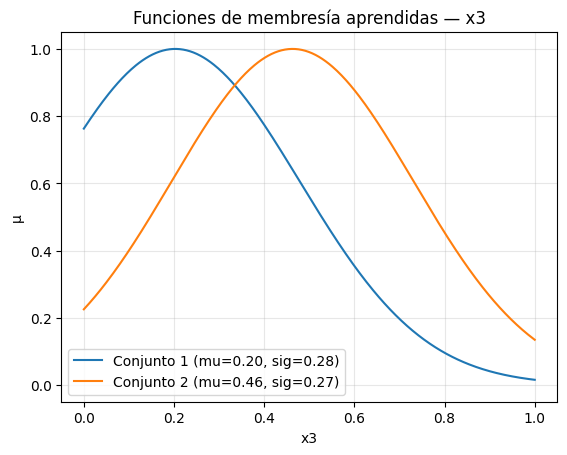

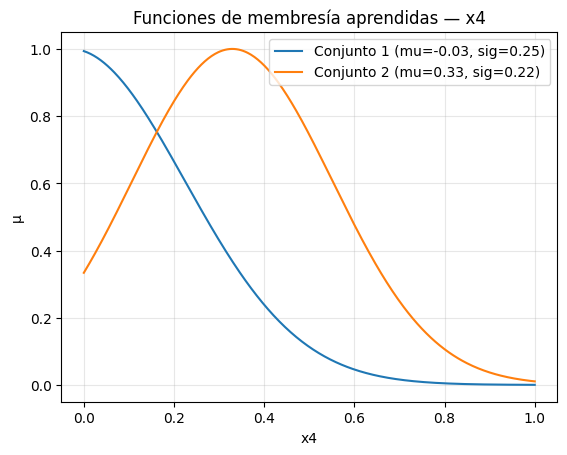

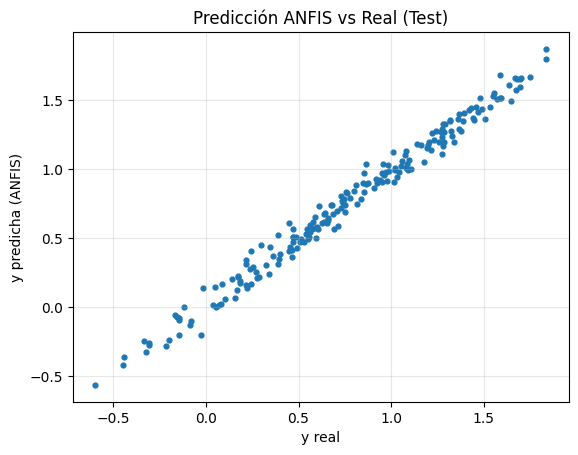


TABLERO INTERACTIVO (sliders)



interactive(children=(FloatSlider(value=0.5, description='x1', max=1.0, step=0.01), FloatSlider(value=0.5, des…

In [3]:
# =============================================================================
# Title   : ANFIS (First-Order Sugeno) in Google Colab — Complete Example
# Topic   : Adaptive Neuro-Fuzzy Inference System (ANFIS) with 4 Inputs and 1 Output
# Course  : Models and Methods of Intelligent Systems
# Author  : Dr.-Ing. Cesar Hernando Valencia Niño
# Date    : 2026-01-27
#
# Overview
# --------
# This notebook provides a fully reproducible ANFIS example:
#   - Synthetic dataset: 4 input variables (x1..x4) and 1 output variable (y)
#   - Dataset size: 1000 samples
#   - End-to-end training using PyTorch (gradient-based learning)
#   - Visualization of learned fuzzy sets (Gaussian membership functions)
#   - Interactive dashboard (sliders) to modify inputs and observe the
#     Sugeno defuzzification output in real time
#
# Notes
# -----
# - The ANFIS implemented here is a first-order Sugeno model:
#     y = Σ_r (w_r * f_r(x)) / Σ_r (w_r)
#   where w_r is the rule firing strength and f_r(x) is a linear consequent.
# - Inputs are generated in [0, 1] to simplify interpretation and UI sliders.
# =============================================================================


# =========================
# 1) Imports
# =========================
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Para el tablero interactivo en Colab
from ipywidgets import interact, FloatSlider, VBox, HBox, HTML
from IPython.display import display

# Reproducibilidad
np.random.seed(42)
torch.manual_seed(42)

# Usar GPU si existe (opcional)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# =========================
# 2) Generación de la base sintética (4 entradas, 1 salida)
# =========================
N = 1000

# Entradas en [0, 1] para facilidad de interpretación en sliders
X = np.random.rand(N, 4).astype(np.float32)
x1, x2, x3, x4 = X[:, 0], X[:, 1], X[:, 2], X[:, 3]

# Función "verdad" (no lineal) + ruido
# Puedes cambiarla por otra relación si quieres.
noise = 0.03 * np.random.randn(N).astype(np.float32)
y = (
    np.sin(np.pi * x1) +
    0.5 * (x2 ** 2) -
    1.0 * x3 +
    np.exp(-2.0 * x4) +
    noise
).astype(np.float32)

# Convertir a tensores
X_t = torch.tensor(X, device=device)             # [N,4]
y_t = torch.tensor(y, device=device).view(-1, 1) # [N,1]

# Split train/test simple
idx = np.random.permutation(N)
train_size = int(0.8 * N)
train_idx, test_idx = idx[:train_size], idx[train_size:]

X_train, y_train = X_t[train_idx], y_t[train_idx]
X_test, y_test   = X_t[test_idx],  y_t[test_idx]

print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape, y_test.shape)

# =========================
# 3) Implementación ANFIS (Sugeno 1er orden)
# =========================
class ANFIS(nn.Module):
    """
    ANFIS de tipo Sugeno de 1er orden:
    - Antecedentes: MFs Gaussianas por cada variable
    - Reglas: producto de membresías (AND)
    - Consecuentes: f_r(x) = a_r0 + a_r1*x1 + ... + a_r4*x4
    - Salida: y = sum_r(w_r * f_r) / sum_r(w_r)
    """
    def __init__(self, n_inputs=4, n_mfs=2):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        self.n_rules = (n_mfs ** n_inputs)

        # Parámetros de MFs Gaussianas por variable:
        # mu: centros, sigma: desviaciones
        # shape: [n_inputs, n_mfs]
        # Inicialización razonable: centros repartidos en [0,1], sigma moderada
        init_mus = torch.linspace(0.2, 0.8, n_mfs).repeat(n_inputs, 1)
        init_sig = 0.2 * torch.ones(n_inputs, n_mfs)

        self.mu = nn.Parameter(init_mus)              # entrenable
        self.log_sigma = nn.Parameter(torch.log(init_sig))  # sigma>0 usando exp()

        # Consecuentes (lineales) por regla:
        # a: [n_rules, (n_inputs+1)]  (incluye bias a_r0)
        self.a = nn.Parameter(torch.zeros(self.n_rules, n_inputs + 1))

        # Precomputar índices de combinación de MFs para reglas
        # Ej: si n_inputs=4 y n_mfs=2 => 16 reglas
        combos = self._build_rule_index()
        self.register_buffer("rule_index", combos)  # [n_rules, n_inputs]

    def _build_rule_index(self):
        # Devuelve tensor con todas las combinaciones de MFs por input
        # Cada fila es una regla: [mf_idx_x1, mf_idx_x2, mf_idx_x3, mf_idx_x4]
        grids = torch.meshgrid(*[torch.arange(self.n_mfs) for _ in range(self.n_inputs)], indexing="ij")
        combos = torch.stack([g.reshape(-1) for g in grids], dim=1)  # [n_rules, n_inputs]
        return combos

    def gaussian_mf(self, x, mu, sigma):
        # x: [B], mu/sigma: [n_mfs] -> salida [B, n_mfs]
        # MF Gaussiana: exp(-0.5 * ((x-mu)/sigma)^2)
        return torch.exp(-0.5 * ((x.unsqueeze(1) - mu.unsqueeze(0)) / sigma.unsqueeze(0)) ** 2)

    def forward(self, X):
        """
        X: [B, n_inputs]
        Retorna:
        y_hat: [B,1]
        extra: dict con info útil (membresías, firing strengths, etc.)
        """
        B = X.shape[0]
        sigma = torch.exp(self.log_sigma)  # [n_inputs, n_mfs], positivo

        # 1) Membresías por variable: list de [B, n_mfs]
        mf_list = []
        for i in range(self.n_inputs):
            mf_i = self.gaussian_mf(X[:, i], self.mu[i], sigma[i])  # [B, n_mfs]
            mf_list.append(mf_i)

        # 2) Firing strength por regla: producto de membresías seleccionadas
        # rule_index: [n_rules, n_inputs] con el índice de MF por cada input
        # Construimos w: [B, n_rules]
        w = torch.ones(B, self.n_rules, device=X.device)
        for i in range(self.n_inputs):
            # mf_list[i]: [B, n_mfs]
            # seleccionar la MF correspondiente a cada regla
            # mf_sel: [B, n_rules]
            mf_sel = mf_list[i][:, self.rule_index[:, i]]
            w = w * mf_sel

        # Evitar división por 0
        w_sum = torch.sum(w, dim=1, keepdim=True) + 1e-8  # [B,1]
        w_norm = w / w_sum  # [B, n_rules]

        # 3) Consecuentes: f_r(x) = a_r0 + sum_i a_ri*x_i
        # Añadir bias: X_aug = [1, x1, x2, x3, x4]
        ones = torch.ones(B, 1, device=X.device)
        X_aug = torch.cat([ones, X], dim=1)  # [B, n_inputs+1]

        # f: [B, n_rules] = X_aug @ a^T
        f = X_aug @ self.a.t()

        # 4) Salida Sugeno (defuzzificación): suma ponderada
        y_hat = torch.sum(w_norm * f, dim=1, keepdim=True)  # [B,1]

        extra = {
            "mf_list": mf_list,     # membresías por variable
            "w": w,                 # firing strengths sin normalizar
            "w_norm": w_norm,       # firing strengths normalizadas
            "f": f                  # consecuentes por regla
        }
        return y_hat, extra

# =========================
# 4) Entrenamiento
# =========================
n_mfs = 2  # 2 conjuntos por variable => 2^4 = 16 reglas
model = ANFIS(n_inputs=4, n_mfs=n_mfs).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

def evaluate(model, Xv, yv):
    model.eval()
    with torch.no_grad():
        yhat, _ = model(Xv)
        mse = criterion(yhat, yv).item()
        rmse = float(np.sqrt(mse))
    return mse, rmse

epochs = 250
for ep in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()

    yhat, _ = model(X_train)
    loss = criterion(yhat, y_train)
    loss.backward()
    optimizer.step()

    if ep % 25 == 0 or ep == 1:
        mse_tr, rmse_tr = evaluate(model, X_train, y_train)
        mse_te, rmse_te = evaluate(model, X_test, y_test)
        print(f"Epoch {ep:3d} | Train RMSE={rmse_tr:.4f} | Test RMSE={rmse_te:.4f}")

# =========================
# 5) Resultados: cómo quedaron las variables y sus conjuntos difusos
# =========================
model.eval()
sigma = torch.exp(model.log_sigma).detach().cpu().numpy()
mu = model.mu.detach().cpu().numpy()

var_names = ["x1", "x2", "x3", "x4"]

print("\n=== Parámetros aprendidos de las funciones de membresía (Gaussianas) ===")
for i, name in enumerate(var_names):
    print(f"\nVariable {name}:")
    for j in range(n_mfs):
        print(f"  Conjunto {j+1}: mu={mu[i, j]:.4f}, sigma={sigma[i, j]:.4f}")

# =========================
# 6) Gráficas de las funciones de membresía por variable
# =========================
def plot_mfs(mu, sigma, var_name, grid_min=0.0, grid_max=1.0, n_points=400):
    xg = np.linspace(grid_min, grid_max, n_points).astype(np.float32)
    plt.figure()
    for j in range(mu.shape[0]):
        # Gaussiana
        ymf = np.exp(-0.5 * ((xg - mu[j]) / sigma[j]) ** 2)
        plt.plot(xg, ymf, label=f"Conjunto {j+1} (mu={mu[j]:.2f}, sig={sigma[j]:.2f})")
    plt.title(f"Funciones de membresía aprendidas — {var_name}")
    plt.xlabel(var_name)
    plt.ylabel("μ")
    plt.ylim(-0.05, 1.05)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

for i, name in enumerate(var_names):
    plot_mfs(mu[i], sigma[i], name)

# =========================
# 7) Comparación rápida (pred vs real) en test
# =========================
with torch.no_grad():
    yhat_test, _ = model(X_test)
yhat_test_np = yhat_test.detach().cpu().numpy().ravel()
y_test_np = y_test.detach().cpu().numpy().ravel()

plt.figure()
plt.scatter(y_test_np, yhat_test_np, s=12)
plt.title("Predicción ANFIS vs Real (Test)")
plt.xlabel("y real")
plt.ylabel("y predicha (ANFIS)")
plt.grid(True, alpha=0.3)
plt.show()

# =========================
# 8) Tablero interactivo: ajustar entradas y ver defuzzificación
# =========================
# Nota: Para Sugeno, la "defuzzificación" es la media ponderada:
# y = sum_r(w_r * f_r) / sum_r(w_r)

def anfis_infer_single(x1, x2, x3, x4, show_details=True):
    # Empaquetar entrada
    Xs = torch.tensor([[x1, x2, x3, x4]], dtype=torch.float32, device=device)
    model.eval()
    with torch.no_grad():
        yhat, extra = model(Xs)

    y_val = float(yhat.item())

    if not show_details:
        print(f"Salida ANFIS (defuzzificación Sugeno): y = {y_val:.6f}")
        return

    # Extraer cosas útiles para visualizar
    w = extra["w"].detach().cpu().numpy().ravel()         # [n_rules]
    w_norm = extra["w_norm"].detach().cpu().numpy().ravel()
    f = extra["f"].detach().cpu().numpy().ravel()

    # Mostrar resumen
    print("=== Entrada ===")
    print(f"x1={x1:.3f}, x2={x2:.3f}, x3={x3:.3f}, x4={x4:.3f}")
    print("\n=== Defuzzificación Sugeno (media ponderada) ===")
    print(f"y = sum_r(w_norm[r] * f[r]) = {y_val:.6f}")

    # Mostrar top reglas activas
    topk = 6
    idx_sorted = np.argsort(-w_norm)[:topk]

    print(f"\n=== Top {topk} reglas por activación (w_norm) ===")
    for k, ridx in enumerate(idx_sorted, 1):
        rule_mfs = model.rule_index[ridx].detach().cpu().numpy()
        rule_str = " AND ".join([f"{var_names[i]} es Conjunto {int(rule_mfs[i])+1}" for i in range(4)])
        print(f"{k}. Regla {ridx:02d}: {rule_str}")
        print(f"   w_norm={w_norm[ridx]:.6f} | f={f[ridx]:.6f} | contrib={w_norm[ridx]*f[ridx]:.6f}")

    # Barra de activaciones normalizadas
    plt.figure()
    plt.bar(np.arange(model.n_rules), w_norm)
    plt.title("Activación normalizada por regla (w_norm)")
    plt.xlabel("Índice de regla")
    plt.ylabel("w_norm")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Barra de consecuentes f por regla
    plt.figure()
    plt.bar(np.arange(model.n_rules), f)
    plt.title("Consecuente f(x) por regla")
    plt.xlabel("Índice de regla")
    plt.ylabel("f")
    plt.grid(True, alpha=0.3)
    plt.show()

# Sliders en [0,1] (porque la base sintética se generó en ese rango)
ui = {
    "x1": FloatSlider(value=0.50, min=0.0, max=1.0, step=0.01, description="x1"),
    "x2": FloatSlider(value=0.50, min=0.0, max=1.0, step=0.01, description="x2"),
    "x3": FloatSlider(value=0.50, min=0.0, max=1.0, step=0.01, description="x3"),
    "x4": FloatSlider(value=0.50, min=0.0, max=1.0, step=0.01, description="x4"),
}

print("\n=========================")
print("TABLERO INTERACTIVO (sliders)")
print("=========================\n")
interact(lambda x1, x2, x3, x4: anfis_infer_single(x1, x2, x3, x4, show_details=True),
         x1=ui["x1"], x2=ui["x2"], x3=ui["x3"], x4=ui["x4"]);
